In [3]:
import sys; sys.path.append("..")

import numpy as np
import logging

from numpy import pi
from dedalus.extras import flow_tools

from dedaLES import dedaLES as dedaLES
from dedalus.extras.plot_tools import plot_bot_3d

# from dedaLES import mpiprint

logger = logging.getLogger(__name__)

def log_magnitude(xmesh, ymesh, data):
    '''
    Log magnitude function for scaling a magnitude for plotting
    complex valueds scalar fields
    '''
    return xmesh, ymesh, np.log10(np.abs(data))

# Parameters
nx = ny = nz = 8
Lx = Ly = Lz = 2*pi

# Homoegneous Navier-Stokes equations
closure = None
model = dedaLES.NavierStokesTriplyPeriodicFlow(nx=nx, ny=ny, nz=nz, Lx=Lx, Ly=Ly, Lz=Lz,
                                               ν=1.0, closure=closure)
model.build_solver()

# Random initial condition. Re_k = u k / ν => u ~ ν * Re_k / k
Re = 1000.0 # Re at grid scale
u0 = Re/nx
model.u['g'] = u0 * dedaLES.random_noise(model.domain, seed=23)
model.v['g'] = u0 * dedaLES.random_noise(model.domain, seed=42)

model.u['g'] = model.u['g'] - np.mean(model.u['g'])
model.v['g'] = model.v['g'] - np.mean(model.v['g'])

# Diagnose w from continuity
ux = model.domain.new_field()
vy = model.domain.new_field()
wz = model.domain.new_field()
model.u.differentiate('x', out=ux)
model.v.differentiate('y', out=vy)
model.w.differentiate('z', out=wz)

wz['g'] = - ux['g'] - vy['g']
wz.integrate('z', out=model.w)

# Plot energy spectra...

# Run the simulation
max_u = np.max(model.u['g'])
dt = 0.1 * 2*pi/(max_u*nx) # grid-scale turbulence time-scale = 1/(u*k)
cadence = 10

flow = flow_tools.GlobalFlowProperty(model.solver, cadence=cadence)
flow.add_property("sqrt(u*u + v*v + w*w) / ν", name='Re')

def average_Re(model): return flow.volume_average('Re')
def max_Re(model): return flow.max('Re')

# model.add_log_tasks(avg_Re=average_Re, max_Re=max_Re)
model.stop_at(sim_time=np.inf, wall_time=np.inf, iteration=100)

2019-02-18 05:31:00,559 pencil 0/1 INFO :: Building pencil matrix 1/28 (~4%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+02/s
2019-02-18 05:31:00,571 pencil 0/1 INFO :: Building pencil matrix 3/28 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2019-02-18 05:31:00,598 pencil 0/1 INFO :: Building pencil matrix 6/28 (~21%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2019-02-18 05:31:00,629 pencil 0/1 INFO :: Building pencil matrix 9/28 (~32%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2019-02-18 05:31:00,654 pencil 0/1 INFO :: Building pencil matrix 12/28 (~43%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2019-02-18 05:31:00,676 pencil 0/1 INFO :: Building pencil matrix 15/28 (~54%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2019-02-18 05:31:00,704 pencil 0/1 INFO :: Building pencil matrix 18/28 (~64%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2019-02-18 05:31:00,741 pencil 0/1 INFO :: Building pencil matrix 21/28 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2019-02-18 05:31:00,7

2019-02-18 05:31:15,263 solvers 0/1 INFO :: Stop iteration reached.


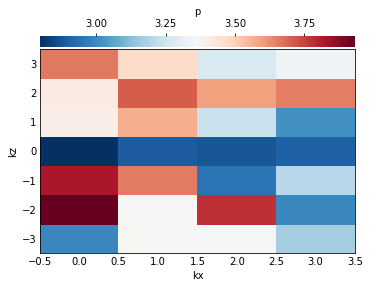

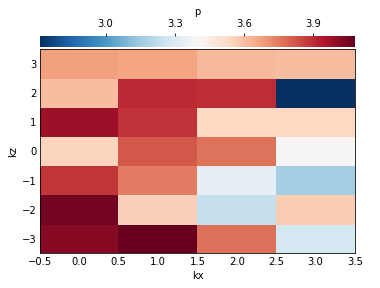

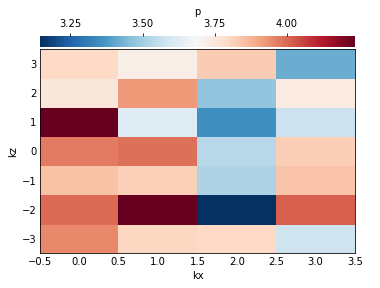

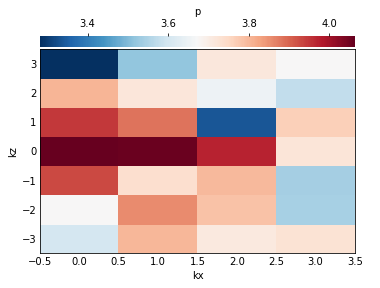

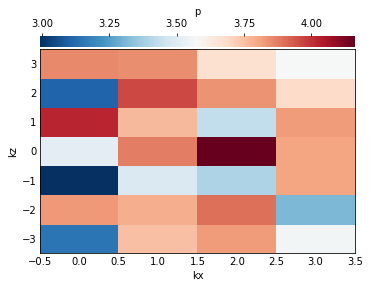

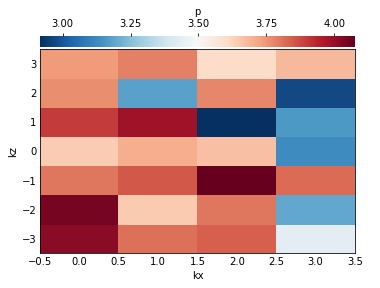

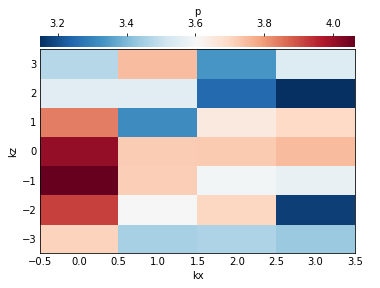

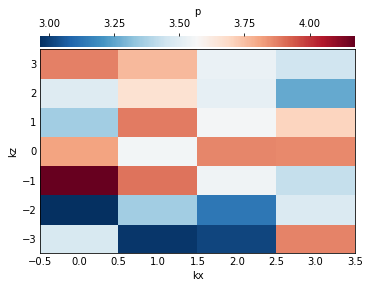

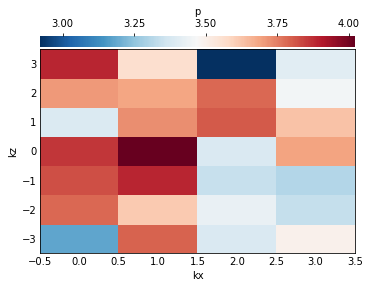

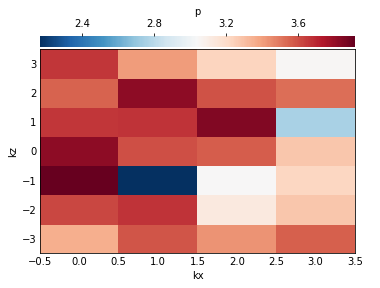

In [4]:
# Run the simulation, plot the pressure field occasionally
while model.solver.ok:
    model.solver.step(dt)
    if model.solver.iteration % 10 == 0:
        plot_bot_3d(model.solver.state['p'], 1, 1, func=log_magnitude);